In [1]:
import pandas as pd
import numpy as np 
import re 
import string
import matplotlib.pyplot as plt
import seaborn as sns
import spacy

from sklearn import metrics 
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix,roc_auc_score,classification_report
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC


In [2]:
column_names=['Tweet_ID','Entity','Sentiment','Tweet_content']

train = pd.read_csv("twitter_training.csv", sep=',',names=column_names)

validation = pd.read_csv("twitter_validation.csv", sep=',',names=column_names)



In [4]:
train.head()

,Tweet_ID,Entity,Sentiment,Tweet_content
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [5]:
train.shape

(74682, 4)

EDA


In [6]:
print(f"Train dataset shape {train.shape}")
print(f"Validation dataset shape {validation.shape}")

Train dataset shape (74682, 4)
Validation dataset shape (1000, 4)


In [7]:
# checking nan values 
print("\t\t\tTrain dataset")
print(train.isna().sum())
print("*"*40)
print("\t\t\tValidation dataset")
print(validation.isna().sum())

			Train dataset
Tweet_ID           0
Entity             0
Sentiment          0
Tweet_content    686
dtype: int64
****************************************
			Validation dataset
Tweet_ID         0
Entity           0
Sentiment        0
Tweet_content    0
dtype: int64


In [8]:
# checking duplicated values
print("\t\t\tTrain dataset")
print(train.duplicated().sum())
print("*"*40)
print("\t\t\tValidation dataset")
print(validation.duplicated().sum())

			Train dataset
2700
****************************************
			Validation dataset
0


In [3]:
# remove dupicate and nan values
train.dropna(inplace=True)
train.drop_duplicates(inplace=True)

In [4]:
# checking duplicated values
print("\t\t\tTrain dataset")
print(train.duplicated().sum())
print("*"*40)
print("\t\t\tValidation dataset")
print(validation.duplicated().sum())

			Train dataset
0
****************************************
			Validation dataset
0


In [5]:
def remove_urls(text):
    """Removes URLs from the given text"""
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)


def remove_emojis(text):
    """Removes emojis from the given text"""
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emojis
                               u"\U0001F300-\U0001F5FF"  # symbols and diagrams
                               u"\U0001F680-\U0001F6FF"  # transport and various places
                               u"\U0001F1E0-\U0001F1FF"  # national flags
                               u"\U00002702-\U000027B0"  # dingbats
                               u"\U000024C2-\U0001F251"  # symbolic signs
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [6]:
train['Tweet_content'] = train['Tweet_content'].apply(lambda x: remove_emojis(x))
train['Tweet_content'] = train['Tweet_content'].apply(lambda x: remove_urls(x))

validation['Tweet_content'] = validation['Tweet_content'].apply(lambda x: remove_emojis(x))
validation['Tweet_content'] = validation['Tweet_content'].apply(lambda x: remove_urls(x))

In [7]:
train['text_lens']=train['Tweet_content'].apply(lambda x: len(x))
validation['text_lens']=validation['Tweet_content'].apply(lambda x: len(x))

## **Data visualisation**

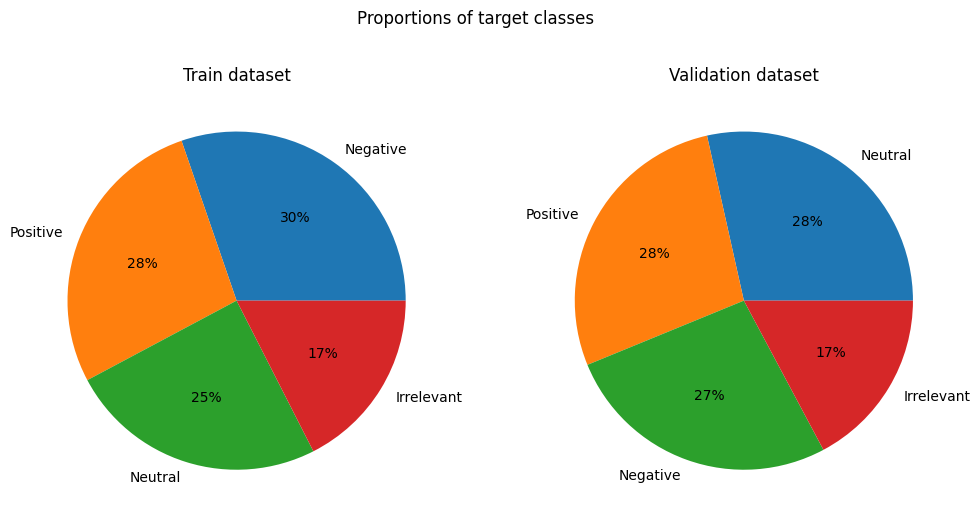

In [8]:
fig , ax = plt.subplots(1,2,figsize=(12,6))

ax[0].pie(train['Sentiment'].value_counts(),labels=train['Sentiment'].value_counts().index,autopct='%.f%%')
ax[1].pie(validation['Sentiment'].value_counts(),labels=validation['Sentiment'].value_counts().index,autopct='%.f%%')

fig.suptitle("Proportions of target classes")
ax[0].set_title("Train dataset")
ax[1].set_title("Validation dataset")

plt.show()

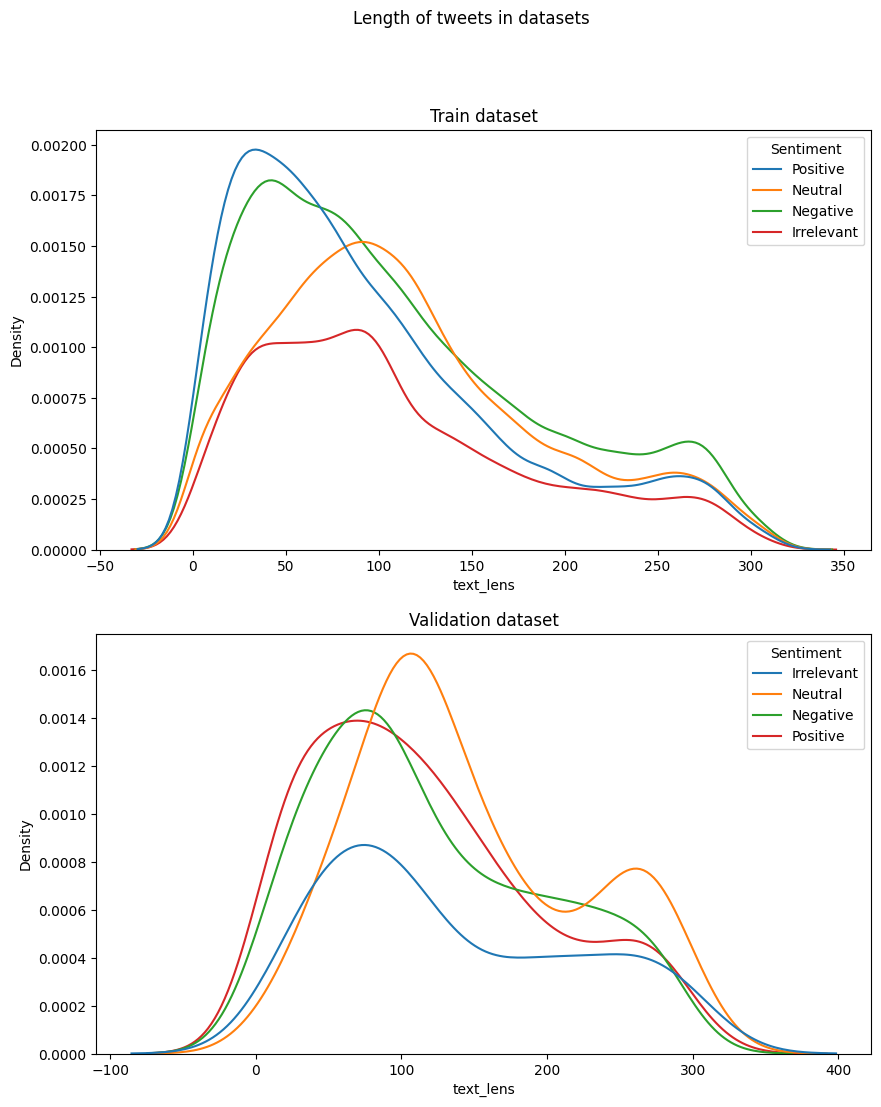

In [20]:
fig ,ax = plt.subplots(2,1,figsize=(10,12))

sns.kdeplot(data=train,x='text_lens',hue='Sentiment',ax=ax[0])
sns.kdeplot(data=validation,x='text_lens',hue='Sentiment',ax=ax[1])

fig.suptitle("Length of tweets in datasets")
ax[0].set_title("Train dataset")
ax[1].set_title("Validation dataset")

plt.show()

# **data cleaning**


In [10]:
def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out

#remove outliers
train = remove_outlier(train,'text_lens')

In [11]:
nlp=spacy.load('en_core_web_sm')

def preprocess(text):
    doc = nlp(text)
    filtered_tokens=[]
    for token in doc:
        if not token.is_stop and not token.is_punct:
            filtered_tokens.append(token.lemma_)
    return " ".join(filtered_tokens)
    

train['preprocessed_text']=train['Tweet_content'].apply(lambda x: preprocess(x))
validation['preprocessed_text']=validation['Tweet_content'].apply(lambda x: preprocess(x))

In [12]:
from sklearn.model_selection import train_test_split

X_train ,X_test , y_train, y_test = train_test_split(
    train[['preprocessed_text']],
    train[['Sentiment']],
    test_size=0.2,
    random_state=42
)

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer= TfidfVectorizer()

X_train_vect= vectorizer.fit_transform(X_train['preprocessed_text'])
X_test_vect= vectorizer.transform(X_test['preprocessed_text'])

y_train=y_train['Sentiment'].map({"Positive":0,"Negative":1,"Neutral":2,"Irrelevant":3})
y_test=y_test['Sentiment'].map({"Positive":0,"Negative":1,"Neutral":2,"Irrelevant":3})



In [14]:
validation_X = vectorizer.transform(validation['preprocessed_text'])
validation_y = validation['Sentiment'].map({"Positive":0,"Negative":1,"Neutral":2,"Irrelevant":3})

## Machine Learning 



# **MultinomialNB**


In [15]:
model = MultinomialNB()
model.fit(X_train_vect,y_train)
y_predict= model.predict(X_test_vect)
accuracy1 = accuracy_score(y_test,y_predict)
print(classification_report(y_test,y_predict))

              precision    recall  f1-score   support

           0       0.70      0.80      0.74      3900
           1       0.65      0.89      0.75      4238
           2       0.84      0.64      0.73      3518
           3       0.94      0.44      0.60      2516

    accuracy                           0.72     14172
   macro avg       0.78      0.69      0.70     14172
weighted avg       0.76      0.72      0.72     14172



# **RandomForestClassifier**

In [16]:
model = RandomForestClassifier()
model.fit(X_train_vect,y_train)
y_predict= model.predict(X_test_vect)
accuracy2 = accuracy_score(y_test,y_predict)
print(classification_report(y_test,y_predict))

              precision    recall  f1-score   support

           0       0.85      0.94      0.89      3900
           1       0.92      0.92      0.92      4238
           2       0.93      0.90      0.91      3518
           3       0.97      0.86      0.91      2516

    accuracy                           0.91     14172
   macro avg       0.92      0.90      0.91     14172
weighted avg       0.91      0.91      0.91     14172



# **ExtraTreesClassifier**

In [17]:
model_extra = ExtraTreesClassifier()
model_extra.fit(X_train_vect,y_train)
y_predict= model_extra.predict(X_test_vect)
accuracy3 = accuracy_score(y_test,y_predict)
print(classification_report(y_test,y_predict))

              precision    recall  f1-score   support

           0       0.86      0.95      0.90      3900
           1       0.94      0.93      0.94      4238
           2       0.95      0.91      0.93      3518
           3       0.97      0.88      0.93      2516

    accuracy                           0.92     14172
   macro avg       0.93      0.92      0.92     14172
weighted avg       0.93      0.92      0.92     14172



# **Logistic Regression**

In [18]:
logreg = LogisticRegression()
logreg.fit(X_train_vect, y_train)
y_predict= logreg.predict(X_test_vect)
accuracy4 = accuracy_score(y_test,y_predict)
print(classification_report(y_test,y_predict))

              precision    recall  f1-score   support

           0       0.78      0.79      0.78      3900
           1       0.75      0.85      0.80      4238
           2       0.79      0.74      0.76      3518
           3       0.82      0.67      0.74      2516

    accuracy                           0.78     14172
   macro avg       0.78      0.76      0.77     14172
weighted avg       0.78      0.78      0.77     14172



C:\Program Files\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# **SVC_(Support Vector Classifier)**

In [19]:
svc = SVC()
svc.fit(X_train_vect, y_train)
y_predict= svc.predict(X_test_vect)
accuracy5 = accuracy_score(y_test,y_predict)
print(classification_report(y_test,y_predict))

              precision    recall  f1-score   support

           0       0.86      0.94      0.90      3900
           1       0.92      0.93      0.92      4238
           2       0.93      0.89      0.91      3518
           3       0.96      0.87      0.91      2516

    accuracy                           0.91     14172
   macro avg       0.92      0.91      0.91     14172
weighted avg       0.92      0.91      0.91     14172



# **SVM (support vector machine)**

In [21]:
svm_model = SVC(kernel='linear')
svm_model.fit(X_train_vect, y_train)
y_predict= svm_model.predict(X_test_vect)
accuracy6 = accuracy_score(y_test,y_predict)
print(classification_report(y_test,y_predict))

              precision    recall  f1-score   support

           0       0.76      0.86      0.81      3900
           1       0.84      0.85      0.84      4238
           2       0.86      0.79      0.83      3518
           3       0.88      0.76      0.81      2516

    accuracy                           0.82     14172
   macro avg       0.83      0.82      0.82     14172
weighted avg       0.83      0.82      0.82     14172



# Graphs

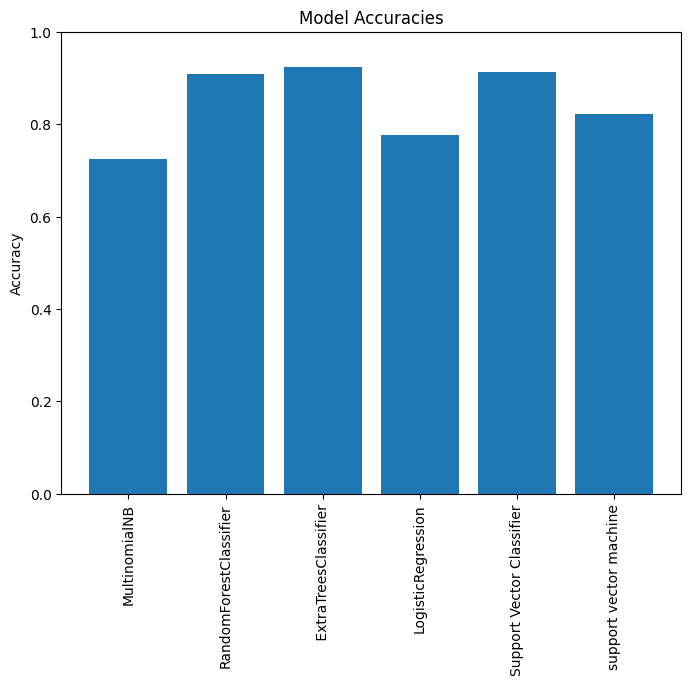

In [30]:
Algomodels = ['MultinomialNB','RandomForestClassifier',' ExtraTreesClassifier','LogisticRegression', 
              'Support Vector Classifier', 'support vector machine']
Accuracies = [accuracy1,accuracy2,accuracy3,accuracy4,accuracy5,accuracy6]
plt.figure(figsize=(8,6))
plt.bar(Algomodels,Accuracies)
plt.title('Model Accuracies')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.xticks(rotation=90)
plt.show()

In [80]:
input_text = 'i bghout this product today and i hate it '
preprocessed_text = preprocess(input_text)
text_final = vectorizer.transform([input_text])
predict = model_extra.predict(text_final)
list(predict)[0]
mapping={0:"Positive",1:"Negative",2:"Neutral",3:"Irrelevant"}
print(mapping[list(predict)[0]])

Negative
